# Исследование моделей для распознавания рукописных цифр из набора MNIST

**Создайте модель для распознавания рукописных цифр из набора MNIST (можно воспользоваться ноутбуком 1-го занятия) и проведите ряд тестов:**

1. Запустите сеть с различными размерами обучающей и проверочной выборок:

    - Обучающая выборка 50.000 примеров
    - Обучающая выборка 10.000 примеров
    - Обучающая выборка 500 примеров

2. Создайте еще два варианта сети и сравните значения точности на проверочной выборке (на последней эпохе) и на тестовой выборке. Сделайте сравнительную таблицу.

3. Создайте сеть следующей архитектуры:

    - 4 Dense слоя
    - Dropout слоя
    - BatchNormalization слоя

Напишите свои выводы по результатам проведенных тестов.

In [32]:
import time
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

from PIL import Image
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

Задать количество эпох для обучения.

In [2]:
EPOCHS = 15

Определить вспомогательную функцию для визуализации процесса обучения.

In [24]:
def plot_history(history: History, n: int):
    _, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue',
        label='loss'
    )
    axes[0].plot(
        history.epoch,
        history.history['val_loss'],
        color='darkblue',
        label='val_loss'
    )
    axes[0].set_title(f"Изменение loss для $n = {n}$")
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon',
        label='accuracy'
    )
    axes[1].plot(
        history.epoch,
        history.history['val_accuracy'],
        color='darkred',
        label='val_accuracy'
    )
    axes[1].set_title(f"Изменение accuracy для $n = {n}$")
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].grid(True)
    axes[1].legend()

    plt.show()

## Подготовка данных

Загрузка данных MNIST:

In [3]:
(x_org, y_org), (x_test_org, y_test_org) = mnist.load_data()

In [4]:
print(f"{x_org.shape}, {x_test_org.shape}")

(60000, 28, 28), (10000, 28, 28)


Отобразить примеры цифр из набора.

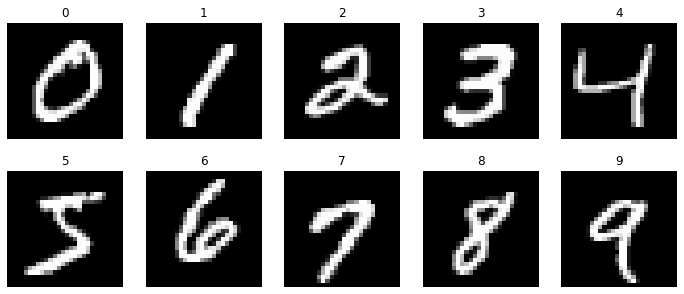

In [5]:
digits = np.unique(y_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit, ax in zip(digits, axes):
    ax.imshow(
        Image.fromarray(x_org[y_org == digit][0]).convert('RGB')
    )

    ax.set_title(str(digit))
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений:

In [6]:
x = x_org.reshape(-1, 28*28).astype(np.float32) / 255
x_test = x_test_org.reshape(-1, 28*28).astype(np.float32) / 255

Преобразовать ответы в унитарный код (one-hot).

In [7]:
y = utils.to_categorical(y_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [8]:
print(f"{y.shape}, {y_test.shape}")

(60000, 10), (10000, 10)


## Исследование влияния объема обучающей выботки на качество обучения нейронной сети

Создать датафрейм для хранения результатов исследования:

In [9]:
report = pd.DataFrame(
    columns=['Train', 'Validation', 'Test', 'Time'],
    index=[50000, 10000, 5000, 1000, 500, 100]
)

### Создание нейронных сетей заданной архитектуры

Вспомогательные классы для создания нейронной сети заданной архитектуры.

In [10]:
class Net(Sequential):

    def __init__(self, *args, **kwargs):
        super(Net, self).__init__(*args, **kwargs)
        self.build()

    def build(self):
        raise NotImplementedError()

    def fit_n(self, x, y, n: int, **kwargs) -> History:
        x_train, x_val, y_train, y_val = train_test_split(
            x,
            y,
            train_size=n
        )

        kwargs['validation_data'] = (x_val, y_val)
        if 'epochs' not in kwargs:
            kwargs['epochs'] = EPOCHS

        return self.fit(
            x_train,
            y_train,
            **kwargs
        )

In [11]:
class SimpleMNISTNet(Net):

    def __init__(self, *args, **kwargs):
        super(SimpleMNISTNet, self).__init__(*args, **kwargs)

    def build(self):
        self.add(Dense(800, input_dim=28*28))
        self.add(Activation('relu'))
        self.add(Dense(400))
        self.add(Activation('relu'))
        self.add(Dense(10))
        self.add(Activation('softmax'))

In [20]:
nets = [SimpleMNISTNet() for _ in report.index]

Выполнить компиляцию нейронных сетей.

In [21]:
for net in nets:
    net.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )

Поскольку все нейронные сети имеют идентичную архитектуру, вывести информацию только о первой из них.

In [22]:
print(nets[0].summary())

Model: "simple_mnist_net_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 800)               628000    
_________________________________________________________________
activation_36 (Activation)   (None, 800)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 400)               320400    
_________________________________________________________________
activation_37 (Activation)   (None, 400)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                4010      
_________________________________________________________________
activation_38 (Activation)   (None, 10)                0         
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
_________________________________________

### Обучение нейронных сетей

Произвести обучение всех нейронных сетей из списка.

In [23]:
histories, times = [], []

pbar = tqdm(desc="Fitting")
pbar.reset(len(nets))

for net, n in zip(nets, report.index):
    start = time.clock()
    history = net.fit_n(x, y, n, verbose=0)

    times.append(time.clock() - start)
    histories.append(history)
    pbar.update()

pbar.refresh();

True

Визуализировать процесс обучения каждой из сетей.

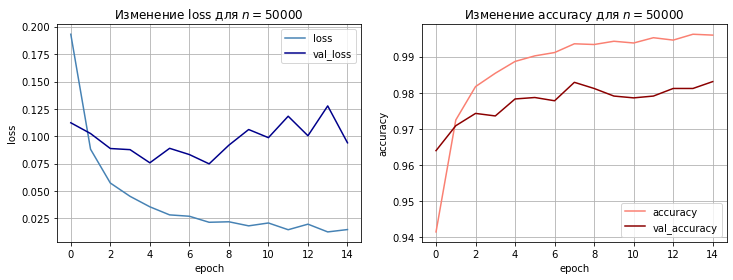

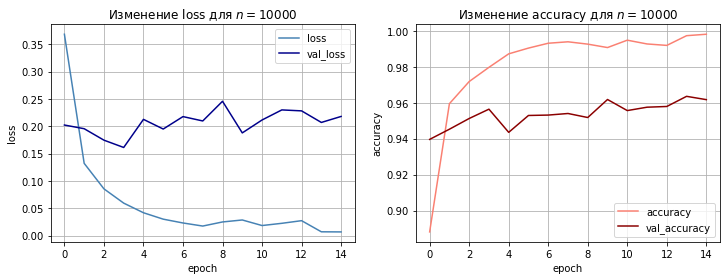

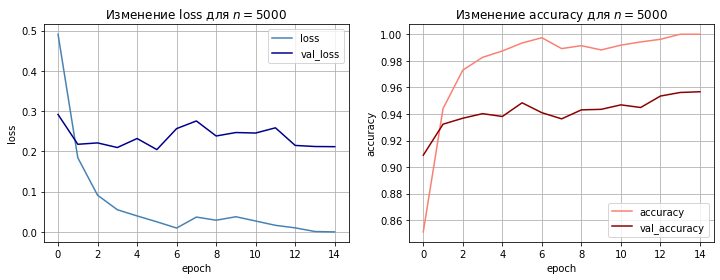

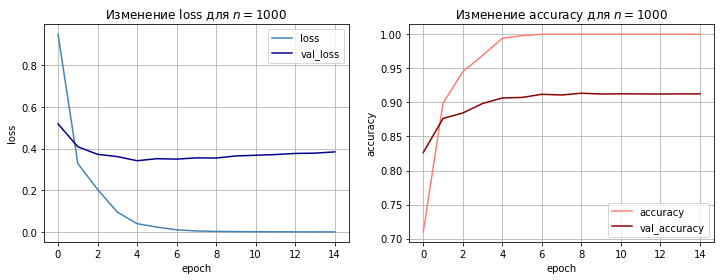

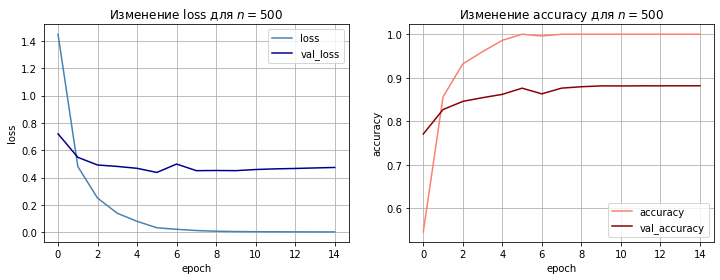

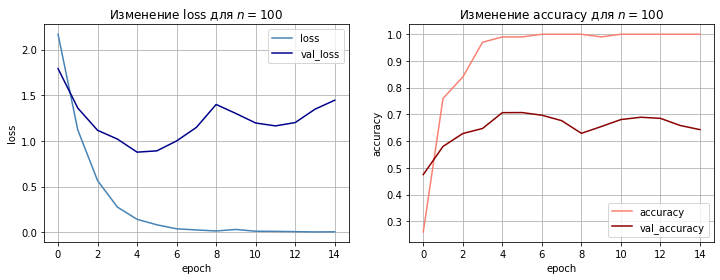

In [25]:
for history, n in zip(histories, report.index):
    plot_history(history, n)

Сохранить веса обученных нейронных сетей.

In [26]:
for net, n in zip(nets, report.index):
    path = Path.home() / f'aiu-02-mnist-light-model-net{n}.h5'

    net.save_weights(path)
    net.load_weights(path)

### Тестирование работы нейронных сетей

Выполнить тестироапние работы каждой из сетей и сохранить результат в таблицу.

In [29]:
pbar = tqdm(desc="Testing")
pbar.reset(len(nets))

for net, n, history, t in zip(nets, report.index, histories, times):
    score = net.evaluate(x_test, y_test, verbose=0)

    report.loc[n, :] = (
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1],
        score[1],
        t
    )
    pbar.update()

pbar.refresh();

## Исследование влияния объема обучающей выботки на качество обучения нейронной сети c Dropout и BatchNormalization

Создать датафрейм для хранения результатов исследования:

In [31]:
adv_report = pd.DataFrame(
    columns=['Train', 'Validation', 'Test', 'Time'],
    index=[50000, 10000, 5000, 1000, 500, 100]
)

### Создание нейронных сетей заданной архитектуры

Вспомогательный класс для создания нейронной сети заданной архитектуры.

In [35]:
class AdvancedMNISTNet(Net):

    DROPOUT_RATE = 0.2

    def __init__(self, *args, **kwargs):
        super(AdvancedMNISTNet, self).__init__(*args, **kwargs)

    def build(self):
        self.add(Dense(800, input_dim=28*28))
        self.add(Activation('relu'))
        self.add(BatchNormalization())

        self.add(Dense(400))
        self.add(Activation('relu'))
        self.add(Dropout(self.DROPOUT_RATE))

        self.add(Dense(200))
        self.add(Activation('relu'))
        self.add(BatchNormalization())

        self.add(Dense(10))
        self.add(Activation('softmax'))

In [36]:
adv_nets = [AdvancedMNISTNet() for _ in adv_report.index]

Выполнить компиляцию нейронных сетей.

In [37]:
for net in adv_nets:
    net.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )

Поскольку все нейронные сети имеют идентичную архитектуру, вывести информацию только о первой из них.

In [38]:
print(adv_nets[0].summary())

Model: "advanced_mnist_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 800)               628000    
_________________________________________________________________
activation_56 (Activation)   (None, 800)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 800)               3200      
_________________________________________________________________
dense_57 (Dense)             (None, 400)               320400    
_________________________________________________________________
activation_57 (Activation)   (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 200)      

### Обучение нейронных сетей

In [39]:
histories, times = [], []

pbar = tqdm(desc="Fitting")
pbar.reset(len(nets))

for net, n in zip(adv_nets, adv_report.index):
    start = time.clock()
    history = net.fit_n(x, y, n, verbose=0)

    times.append(time.clock() - start)
    histories.append(history)
    pbar.update()

pbar.refresh();

Визуализировать процесс обучения каждой из сетей.

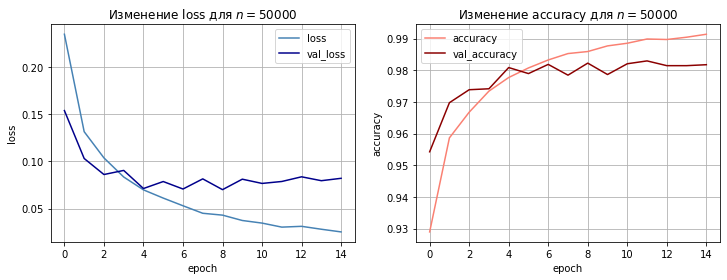

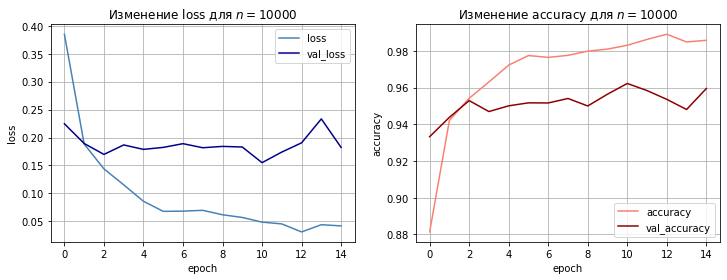

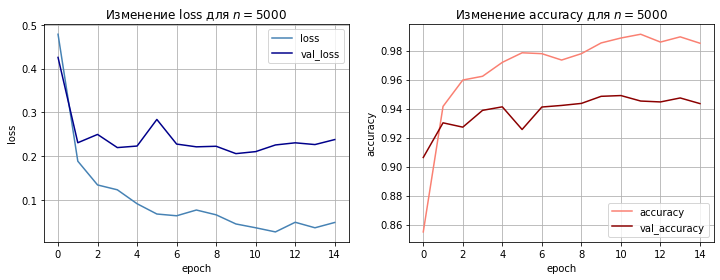

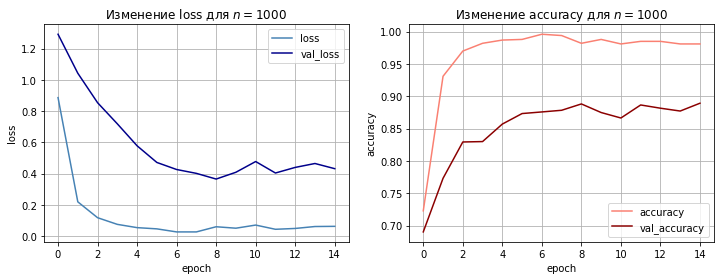

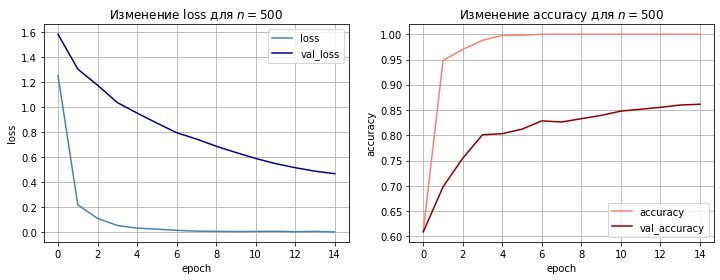

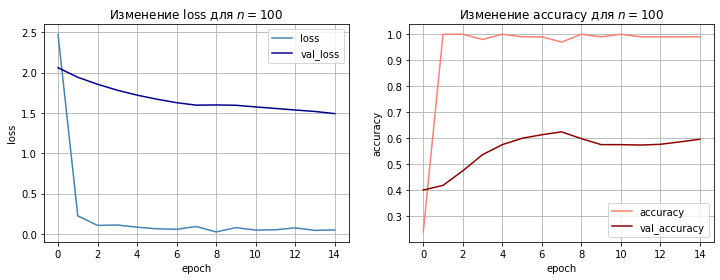

In [40]:
for history, n in zip(histories, adv_report.index):
    plot_history(history, n)

Сохранить веса обученных нейронных сетей.

In [41]:
for net, n in zip(adv_nets, adv_report.index):
    path = Path.home() / f'aiu-02-mnist-light-model-advnet{n}.h5'

    net.save_weights(path)
    net.load_weights(path)

### Тестирование работы нейронных сетей

Выполнить тестироапние работы каждой из сетей и сохранить результат в таблицу.

In [42]:
pbar = tqdm(desc="Testing")
pbar.reset(len(nets))

for net, n, history, t in zip(adv_nets, adv_report.index, histories, times):
    score = net.evaluate(x_test, y_test, verbose=0)

    adv_report.loc[n, :] = (
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1],
        score[1],
        t
    )
    pbar.update()

pbar.refresh();

## Выводы

In [43]:
report

,Train,Validation,Test,Time
50000,0.99596,0.9831,0.9817,176.754
10000,0.9981,0.96174,0.9637,102.533
5000,1,0.956709,0.9585,92.7097
1000,1,0.912508,0.9191,81.2692
500,1,0.881597,0.8873,80.2581
100,1,0.642938,0.6503,79.8187


In [44]:
adv_report

,Train,Validation,Test,Time
50000,0.99142,0.9818,0.9815,220.865
10000,0.9858,0.95952,0.9627,115.784
5000,0.9852,0.943545,0.9481,98.5767
1000,0.981,0.889356,0.899,88.5404
500,1,0.861462,0.8715,86.1755
100,0.99,0.59626,0.5982,85.6794
